In [1]:
# Imports
import pandas as pd
import numpy as np
import psycopg2
import tqdm
from time import gmtime, strftime

In [2]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager
import seaborn as sns

%matplotlib inline

In [3]:
plt.style.use('ggplot')

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#505050'
plt.rcParams['axes.labelcolor']= '#505050'
plt.rcParams['xtick.color'] = '#505050'
plt.rcParams['ytick.color'] = '#505050'
plt.rcParams['font.size']= 11

In [4]:
def countplot_frequency(df, column_name, title, order=None):
    ax = sns.countplot(x=column_name, data=df, order=order)
    plt.title(title)

    # Make twin axis
    ax2 = ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    ncount = len(df)
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(mtick.LinearLocator(11))

    # Fix the frequency range to 0-100
    ax2.set_ylim(0, 100)
    ax.set_ylim(0, ncount)

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)
    return ax, ax2

#### POSTGRESQL

In [5]:
# Notebook
host = '/tmp'

# Locus
# host = '/var/run/postgresql'

con = psycopg2.connect(dbname ='mimic', user='postgres', password="*", host=host)
cur = con.cursor()

### Patients table

In [6]:
pat_query = '''SELECT * FROM mimiciii.patients;'''
mimic_patients_df = pd.read_sql_query(pat_query, con)

### Admission table

In [7]:
adm_query = '''SELECT * FROM mimiciii.admissions;'''
mimic_admission_df = pd.read_sql_query(adm_query, con)

#### Merge both tables and calculate true age

In [8]:
# Merge patient and admission tables
mimic_patients_admission_df = pd.merge(mimic_admission_df, mimic_patients_df, on = 'subject_id' , how = 'inner')

In [9]:
# ADMITTIME and DOB objects to datetime
mimic_patients_admission_df["admittime"] = pd.to_datetime(mimic_patients_admission_df["admittime"], format='%Y%m%d %H:%M:%S')
mimic_patients_admission_df["dob"] = pd.to_datetime(mimic_patients_admission_df["dob"], format='%Y%m%d %H:%M:%S')

# True age
mimic_patients_admission_df["age"] = mimic_patients_admission_df["admittime"].sub(mimic_patients_admission_df["dob"]).dt.days/365.242

# Adult patients only
mimic_patients_admission_df = mimic_patients_admission_df[(mimic_patients_admission_df['age'] >= 18)]


### ICD-9 Codes table

In [10]:
diagnoses_query = '''SELECT * FROM mimiciii.diagnoses_icd;'''
mimic_diagnoses_df = pd.read_sql_query(diagnoses_query, con)

In [11]:
mimic_patients_diagnoses_df = pd.merge(mimic_patients_admission_df, mimic_diagnoses_df, on = ['subject_id', 'hadm_id'], how = 'inner')

### ICD-9 Descriptions table

In [12]:
diagnoses_descriptions_query = '''SELECT * FROM mimiciii.d_icd_diagnoses;'''
mimic_diagnoses_descriptions_df = pd.read_sql_query(diagnoses_descriptions_query, con)

## Occurrence and Mortality

In [13]:
# function by wboeg
def normalize_ethnicity(ethnicity):
    if 'BLACK' in ethnicity:
        return 'black'
    if 'WHITE' in ethnicity:
        return 'white'
    if 'ASIAN' in ethnicity:
        return 'asian'
    if 'LATINO' in ethnicity:
        return 'hispanic'
    if 'HISPANIC' in ethnicity:
        return 'hispanic'
    if 'SOUTH AMERICAN' in ethnicity:
        return 'other'
    if 'CARIBBEAN ISLAND' in ethnicity:
        return 'black'
    if 'AMERICAN INDIAN' in ethnicity:
        return 'other'    
    if 'MIDDLE EASTERN' in ethnicity:
        return 'other'
    if 'MULTI RACE ETHNICITY' in ethnicity:
        return 'other'
    if 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' in ethnicity:
        return 'other'
    if 'PORTUGUESE' in ethnicity:
        return 'other'       
    return 'unknown'

def normalize_insurance(ins):
    if ins in ['Government', 'Medicaid', 'Medicare']:
        return 'Public'
    elif ins == 'Private':
        return 'Private'
    else:
        return 'Self-Pay'

In [14]:
mimic_patients_diagnoses_df['ethnicity'] = mimic_patients_diagnoses_df['ethnicity'].apply(normalize_ethnicity)
mimic_patients_diagnoses_df['insurance'] = mimic_patients_diagnoses_df['insurance'].apply(normalize_insurance)

In [15]:
# Lenght of stay (hours)
los = mimic_patients_diagnoses_df['dischtime'] - mimic_patients_diagnoses_df['admittime']
mimic_patients_diagnoses_df['los'] = los.apply(lambda t:(t.days*24) + (t.seconds/3600))

In [16]:
# We are not considering MULTI RACE ETHNICITY, UNKNOWN or OTHER 
mimic_patients_diagnoses_df = mimic_patients_diagnoses_df[(mimic_patients_diagnoses_df['ethnicity'] != 'other') & (mimic_patients_diagnoses_df['ethnicity'] != 'unknown')]


### ICU Stays (patients details)

link:
https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/cohort-selection.ipynb

"As MIMIC-III is primarily an intensive care unit (ICU) database, the focus will be on patients admitted to and discharged from the ICU. That is, rather than selecting our cohort based off the individual patient (identified by subject_id in the database), we will usually want to select our cohort based off the ICU stay (identified by icustay_id). Thus, it is sensible to begin with the icustays table."

In [17]:
icustay_query = 'SELECT * FROM mimiciii.icustay_detail_v2;' 
icustay_details_df = pd.read_sql_query(icustay_query, con)

In [18]:
# We are not considering MULTI RACE ETHNICITY, NATIVE, UNKNOWN or OTHER 
icustay_details_df = icustay_details_df[(icustay_details_df['ethnicity_grouped'] != 'other') & (icustay_details_df['ethnicity_grouped'] != 'unknown') & (icustay_details_df['ethnicity_grouped'] != 'native')]

# +18 years old (300 years old are patients older than 89)
icustay_details_df = icustay_details_df[(icustay_details_df['age'] >= 18) & (icustay_details_df['age'] < 300)]

# insurance
icustay_details_df['insurance'] = icustay_details_df['insurance'].apply(normalize_insurance)

# icd9 merge
icu_diagnoses_df = pd.merge(icustay_details_df, mimic_diagnoses_df, on = ['subject_id', 'hadm_id'], how = 'inner')

#### Unique patient with multiple rows with same ICD9

In [19]:
# eth_mortality_df = mimic_patients_diagnoses_df.groupby(['icd9_code', 'ethnicity', 'hospital_expire_flag']).size().unstack()

eth_mortality_df = icu_diagnoses_df.groupby(['icd9_code', 'ethnicity_grouped', 'hospital_expire_flag']).size().unstack()
eth_mortality_df = eth_mortality_df.reset_index()
eth_mortality_df.columns.names = [None]
eth_mortality_df.columns = ['icd9_code', 'ethnicity', 'alive', 'dead']
eth_mortality_df.insert(4, 'total', '0')
eth_mortality_df = eth_mortality_df.fillna(0)
eth_mortality_df['total'] = eth_mortality_df['total'].astype(float)

# Compute alive, dead and total
for index, row in eth_mortality_df.iterrows():
    eth_mortality_df.at[index, 'total'] = row['alive'] + row['dead']

In [20]:
# merge mortality with descriptions from each ICD
eth_mortality_df = eth_mortality_df.merge(mimic_diagnoses_descriptions_df, left_on='icd9_code', right_on='icd9_code')

#### Transplanted patients

In [21]:
# Search only for patients with transplant description
transplanted_patients_df = eth_mortality_df[eth_mortality_df['long_title'].str.lower().str.contains('transplant')].copy()

In [22]:
# 1. Mortality significance: only +1 patients dead
transplanted_patients_df = transplanted_patients_df.loc[eth_mortality_df['dead'] > 1]

# 3. Remove ICD9 codes with only ONE ETHNICITY
for index, row in transplanted_patients_df.iterrows():
    rows = transplanted_patients_df.loc[transplanted_patients_df['icd9_code'] == row['icd9_code']]
    if (len(rows) == 1):
        transplanted_patients_df.drop(rows.index, inplace=True)

In [23]:
# pd.set_option("display.max_colwidth", 500, 'display.max_rows', 100)
transplanted_patients_df = transplanted_patients_df.drop(['row_id', 'short_title'], axis=1)

#### Cancer

In [24]:
searchfor = ['neoplasm', 'neoplasms', 'sarcoma', 'carcinoma']
cancer_patients_df = eth_mortality_df[eth_mortality_df['long_title'].str.lower().str.contains('|'.join(searchfor))].copy()

In [25]:
# 1. Mortality significance: only +1 patients dead
cancer_patients_df = cancer_patients_df.loc[cancer_patients_df['dead'] > 1]

# 2. Remove ICD9 codes with only ONE ETHNICITY
for index, row in cancer_patients_df.iterrows():
    rows = cancer_patients_df.loc[cancer_patients_df['icd9_code'] == row['icd9_code']]
    if (len(rows) == 1):
        cancer_patients_df.drop(rows.index, inplace=True)

In [26]:
cancer_patients_df = cancer_patients_df.drop(['row_id', 'short_title'], axis=1)

#### Diabetes

In [27]:
diabetes_patients_df = eth_mortality_df[eth_mortality_df['long_title'].str.lower().str.contains('diabetes')].copy()

In [28]:
# 1. Mortality significance: only +1 patients dead
diabetes_patients_df = diabetes_patients_df.loc[diabetes_patients_df['dead'] > 1]

# 2. Remove ICD9 codes with only ONE ETHNICITY
for index, row in diabetes_patients_df.iterrows():
    rows = diabetes_patients_df.loc[diabetes_patients_df['icd9_code'] == row['icd9_code']]
    if (len(rows) == 1):
        diabetes_patients_df.drop(rows.index, inplace=True)

In [29]:
diabetes_patients_df = diabetes_patients_df.drop(['row_id', 'short_title'], axis=1)

### Cohort

##### HOSPITAL ADMISSIONS FOR EACH ICD9

In [30]:
icd9_list = set(transplanted_patients_df['icd9_code'])
icd9_list.update(cancer_patients_df['icd9_code'])
icd9_list.update(diabetes_patients_df['icd9_code'])

hadm_ids_list = set()
cohort_df = pd.DataFrame()

for icd9 in icd9_list:    
    patients = icu_diagnoses_df.loc[(icu_diagnoses_df["icd9_code"] == icd9)].copy()
    cohort_df = cohort_df.append(patients, ignore_index=True)
    for hadm_id in patients['hadm_id']:
        hadm_ids_list.add(hadm_id)

In [31]:
# REMOVE: same admission multiple times for different ICD9
cohort_df.drop_duplicates(subset='hadm_id', keep='last', inplace=True)

In [32]:
cohort_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'insurance', 'los_hospital', 'age', 'ethnicity',
       'ethnicity_grouped', 'admission_type', 'hospital_expire_flag',
       'hospstay_seq', 'first_hosp_stay', 'intime', 'outtime', 'los_icu',
       'icustay_seq', 'first_icu_stay', 'row_id', 'seq_num', 'icd9_code'],
      dtype='object')

### MIMIC III Population characteristics

In [33]:
# Pollard TJ, Johnson AEW, Raffa JD, Mark RG (2018). tableone: An open source
# Python package for producing summary statistics for research papers.
# JAMIA Open, Volume 1, Issue 1, 1 July 2018, Pages 26-31.
# https://doi.org/10.1093/jamiaopen/ooy012
    
# Table One
from tableone import TableOne

# optionally, a categorical variable for stratification
groupby = ['ethnicity_grouped']

# columns to be summarized
columns = ['gender', 'insurance','los_hospital', 'age'] 

# columns containing categorical variables
categorical = ['gender', 'insurance']

# non-normal variables
nonnormal = ['age', 'los_hospital']

# alternative labels
labels={'los_hospital': 'Length of Stay', 'age': 'Age', 'ethnicity_grouped':'Ethnicity',
        'gender':'Gender', 'insurance':'Insurance'}

# combine all information
grouped_df = cohort_df

# create an instance of TableOne with the input arguments
grouped_table = TableOne(grouped_df, columns, categorical, groupby, nonnormal, rename=labels, isnull=False)

# view tableone
grouped_table

Grouped by Ethnicity                                                      
                                       asian             black          hispanic             white
variable       level                                                                              
n                                        504              2367               738             13548
Gender         F                  197 (39.1)       1326 (56.0)        302 (40.9)       5693 (42.0)
               M                  307 (60.9)       1041 (44.0)        436 (59.1)       7855 (58.0)
Insurance      Private            100 (19.8)        467 (19.7)        129 (17.5)       3960 (29.2)
               Public             403 (80.0)       1887 (79.7)        599 (81.2)       9553 (70.5)
               Self-Pay              1 (0.2)          13 (0.5)          10 (1.4)          35 (0.3)
Length of Stay                7.5 [4.2,13.0]    7.0 [4.0,12.0]    6.5 [4.1,12.0]    7.5 [4.6,12.7]
Age                         66.4 [56.5,76.8]  63.9 [53.9,73.1]  60.2 [50.0,70.5]  68.6 [58.8,77.8]
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: los_hospital.
[2] Warning, Tukey test indicates far outliers in: los_hospital.
[3] Warning, test for normality reports non-normal distributions for: age, los_hospital.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a247fa898>,
      dtype=object)

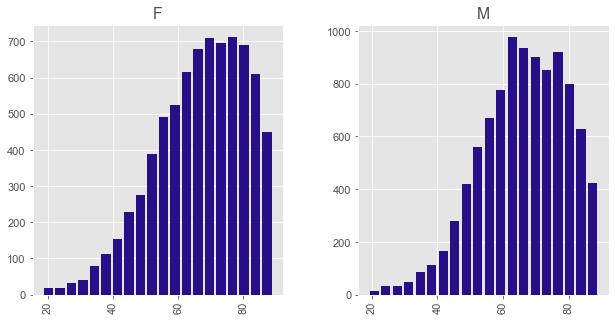

In [34]:
# Total (by gender)
cohort_df.hist(column='age', by='gender', bins=20, color='#271087', zorder=2, rwidth=0.8, figsize=(10, 5))


(<matplotlib.axes._subplots.AxesSubplot at 0x1a24d7f588>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a256eba90>)

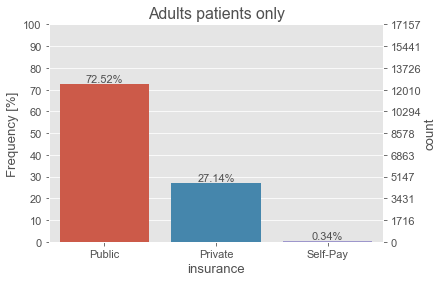

In [35]:
# by insurance
countplot_frequency(cohort_df, 'insurance', 'Adults patients only')

Text(0, 0.5, 'Density')

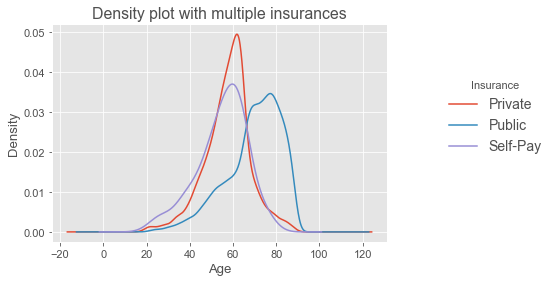

In [36]:
# Insurance by age
cohort_df.groupby('insurance')['age'].plot(kind='density')

plt.legend(prop={'size': 14}, title = 'Insurance', frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.title('Density plot with multiple insurances')
plt.xlabel('Age')
plt.ylabel('Density')

Text(0, 0.5, '# patients')

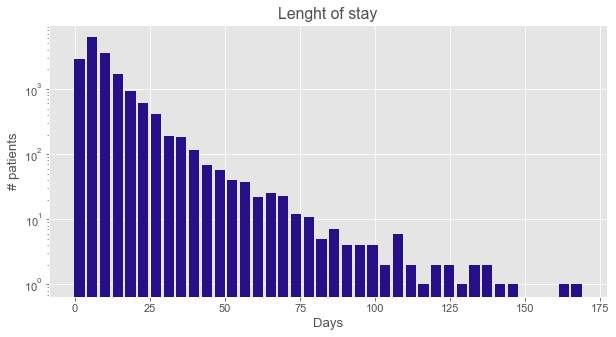

In [40]:
# Lenght of stay
cohort_df.hist(column='los_hospital', bins=40, color='#271087', grid=True, zorder=2, rwidth=0.8, figsize=(10, 5))
plt.yscale('log')
plt.title('Lenght of stay')
plt.xlabel('Days')
plt.ylabel('# patients')

### Oasis score

Oxford Acute Severity of Illness Score (OASIS)
- This score is a measure of severity of illness for patients in the ICU.
- The score is calculated on the first day of each ICU patients' stay.

Variables used in OASIS:
-  Heart rate, GCS, MAP, Temperature, Respiratory rate, Ventilation status (sourced from CHARTEVENTS)
-  Urine output (sourced from OUTPUTEVENTS)
-  Elective surgery (sourced from ADMISSIONS and SERVICES)
-  Pre-ICU in-hospital length of stay (sourced from ADMISSIONS and ICUSTAYS)
-  Age (sourced from PATIENTS)

In [42]:
# Get the OASIS scores (ONLY IF PATIENT WAS ADMITTED TO THE ICU)
oasis_query = 'SELECT distinct hadm_id, max(oasis) as oasis FROM mimiciii.oasis GROUP BY hadm_id'
oasis_df = pd.read_sql_query(oasis_query, con)

In [45]:
def select(scores):
    return {hadm_id: scores[hadm_id] for hadm_id in hadm_ids_list}

# Low: 0-32
# Medium: 33-40
# High: 41+
oasis_scores = dict(oasis_df[['hadm_id','oasis']].values)
patients_oasis_score = select(oasis_scores)